In [1]:
import os
import pickle
from PIL import Image
import numpy as np
import glob
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.links.caffe import CaffeFunction
from matplotlib import pylab as plt

#  データセットを作る

In [2]:
from chainer.datasets import LabeledImageDataset
from itertools import chain
# 画像フォルダ
IMG_DIR = 'datas'
# 各注視点ごとのフォルダ
dnames = glob.glob('{}/*'.format(IMG_DIR))
# キャプチャのパス
fnames = [glob.glob('{}/*.jpg'.format(d)) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
fnames = list(chain.from_iterable(fnames))

labels = [os.path.basename(os.path.dirname(fn)) for fn in fnames]
dnames = [os.path.basename(d) for d in dnames
          if not os.path.exists('{}/ignore'.format(d))]
labels = [dnames.index(l) for l in labels]

d = LabeledImageDataset(list(zip(fnames, labels)))

# 平均画像の作成

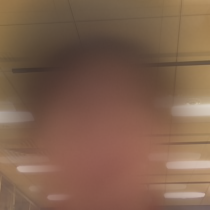

In [3]:
imgArray = None
for fname in fnames:
    im = Image.open(fname)
    if type(imgArray) == type(None):
        imgArray = np.asarray(im)/len(fnames)
    else:
        imgArray += np.asarray(im)/len(fnames)

pilImg = Image.fromarray(np.uint8(imgArray))
pilImg

# データセットを加工する

In [4]:
from chainer.datasets import TransformDataset
from PIL import Image

width, height = 224, 224

# 平均画像を用意する
imgArray = None
for fname in fnames:
    img = Image.open(fname)
    img = img.resize((width, height), Image.BICUBIC)
    im = np.asarray(img, dtype=np.float32).transpose(2, 0, 1)
    if type(imgArray) == type(None):
        imgArray = np.asarray(im)/len(fnames)
    else:
        imgArray += np.asarray(im)/len(fnames)
mean_image = imgArray.copy()

# 各データに行う変換
def transform(inputs):
    img, label = inputs
    img = img[:3, ...]
    img = img.astype(np.uint8)
    img = Image.fromarray(img.transpose(1, 2, 0))
    img = img.resize((width, height), Image.BICUBIC)
    img = np.asarray(img, dtype=np.float32).transpose(2, 0, 1)
    img = img - mean_image
    return img, label

# 変換付きデータセットにする
td = TransformDataset(d, transform)

In [5]:
from chainer import datasets

train_img, valid_img = datasets.split_dataset_random(td, int(len(d) * 0.8), seed=0)

# モデルの読み込み

In [6]:
%%time
MODEL = 'model/bvlc_googlenet.caffemodel'
PICKLE = 'model/ggnet.pkl'
if os.path.exists(PICKLE):
    print("Load pickle")
    with open(PICKLE, 'rb') as pkl:
        model = pickle.load(pkl)
else:
    print("Load caffemodel and make pickle")
    if os.path.exists(MODEL):
        model = CaffeFunction(MODEL)
        with open(PICKLE, 'wb') as pkl:
            pickle.dump(model, pkl)
    print(MODEL + " not found.")

Load caffemodel and make pickle
model/bvlc_googlenet.caffemodel not found.
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 322 µs


# GoogLeNetのモデル

In [7]:
class GoogLeNet(Chain):
    insize = 224
    
    def __init__(self):
        super(GoogLeNet, self).__init__()
        with self.init_scope():
            self.conv1 =  L.Convolution2D(3, 64, 7, stride=2, pad=3)
            self.conv2_reduce = L.Convolution2D(64, 64, 1)
            self.conv2 = L.Convolution2D(64, 192, 3, stride=1, pad=1)
            self.inception_3a = L.Inception(192, 64, 96, 128, 16, 32, 32)
            self.inception_3b = L.Inception(256, 128, 128, 192, 32, 96, 64)
            self.inception_4a = L.Inception(480, 192, 96, 208, 16, 48, 64)
            self.inception_4b = L.Inception(512, 160, 112, 224, 24, 64, 64)
            self.inception_4c = L.Inception(512, 128, 128, 256, 24, 64, 64)
            self.inception_4d = L.Inception(512, 112, 144, 288, 32, 64, 64)
            self.inception_4e = L.Inception(528, 256, 160, 320, 32, 128, 128)
            self.inception_5a = L.Inception(832, 256, 160, 320, 32, 128, 128)
            self.inception_5b = L.Inception(832, 384, 192, 384, 48, 128, 128)
            self.loss3_fc = L.Linear(1024, 1000)
            
            self.loss1_conv = L.Convolution2D(512, 128, 1)
            self.loss1_fc1 = L.Linear(2048, 1024)
            self.loss1_fc2 = L.Linear(1024, 1000)
            
            self.loss2_conv = L.Convolution2D(528, 128, 1)
            self.loss2_fc1 = L.Linear(2048, 1024)
            self.loss2_fc2 = L.Linear(1024, 1000)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 3, stride=2)
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.relu(self.conv2_reduce(h))
        h = F.relu(self.conv2(h))
        h = F.local_response_normalization(h, n=5, k=1, alpha=2e-05)
        h = F.max_pooling_2d(h, 3, stride=2)
        
        h = self.inception_3a(h)
        h = self.inception_3b(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_4a(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss1_conv(b))
        b = F.relu(self.loss1_fc1(b))
        b = self.loss1_fc2(b)
        
        h = self.inception_4b(h)
        h = self.inception_4c(h)
        h = self.inception_4d(h)
        
        b = F.average_pooling_2d(h, 5, stride=3)
        b = F.relu(self.loss2_conv(b))
        b = F.relu(self.loss2_fc1(b))
        b = self.loss2_fc2(b)
        
        h = self.inception_4e(h)
        h = F.max_pooling_2d(h, 3, stride=2)
        h = self.inception_5a(h)
        h = self.inception_5b(h)
        
        h = F.average_pooling_2d(h, 7, stride=1)
        y = self.loss3_fc(F.dropout(h, 0.4))
        return y

In [ ]:
train = train_img
test = valid_img
model = L.Classifier(GoogLeNet())

In [ ]:

dev = 0
if dev >= 0:
    chainer.cuda.get_device(dev).use()
    model.to_gpu()

optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, 100)
test_iter = chainer.iterators.SerialIterator(test, 100, repeat=False, shuffle=False)

epoch = 10000
updater = training.StandardUpdater(train_iter, optimizer, device=dev)
trainer = training.Trainer(updater, (epoch, 'epoch'), out="result")

# Evaluator
trainer.extend(extensions.Evaluator(test_iter, model, device=dev))

# LogReport
trainer.extend(extensions.LogReport())

# PrintReport
trainer.extend(extensions.PrintReport( entries=['epoch', 'main/loss', 'main/accuracy','validation/main/loss', 'validation/main/accuracy', 'elapsed_time' ]))

print("run")
trainer.run()

run
epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           3.75396     0.0280117      3.57544               0.0300997                 88.2943       
2           3.58973     0.0290059      3.57261               0.0321262                 176.71        
3           3.57648     0.032807       3.55395               0.0292359                 265.312       
4           3.376       0.0502924      3.04161               0.0721927                 353.961       
5           2.93576     0.0864706      2.77502               0.101894                  442.128       
6           2.72898     0.112339       2.81278               0.103355                  530.814       
7           2.47643     0.165322       2.17684               0.23804                   619.541       
8           1.89782     0.310468       1.69805               0.397342                  709.447       
9           1.53511     0.436901       1.33897               0.509203           

79          0.124063    0.959824       0.554643              0.857907                  7011.52       
80          0.104115    0.966295       0.582779              0.859469                  7100.67       
81          0.129645    0.954386       0.58296               0.856545                  7189.39       
82          0.116144    0.960819       0.511419              0.874385                  7278.13       
83          0.111329    0.960468       0.61268               0.855282                  7366.75       
84          0.116654    0.960994       0.704595              0.838704                  7455.57       
85          0.109467    0.965          0.65507               0.842027                  7543.72       
86          0.124689    0.957427       0.540256              0.872791                  7632.47       
87          0.0837374   0.97193        0.696893              0.839136                  7721.32       
88          0.158196    0.947076       0.570943              0.836312             

158         0.112262    0.964795       0.44622               0.886345                  14005.9       
159         0.0834564   0.971989       0.500722              0.891927                  14094.2       
160         0.0688417   0.977589       0.479011              0.893322                  14181.9       
161         0.0837862   0.973158       0.477703              0.889203                  14270.2       
162         0.0991152   0.967076       0.502902              0.873322                  14358.4       
163         0.0731494   0.976257       0.622078              0.857973                  14447.1       
164         0.117146    0.961696       0.478298              0.882027                  14535.2       
165         0.0849304   0.971353       0.579614              0.868305                  14622.9       
166         0.0809705   0.974094       0.512691              0.879568                  14710.6       
167         0.1071      0.964561       0.504057              0.883355             

237         0.0739065   0.976083       0.573111              0.877475                  20959.3       
238         0.0816906   0.975205       0.482953              0.894219                  21047.3       
239         0.0624893   0.979766       0.526398              0.900698                  21135.4       
240         0.0801109   0.974765       0.416974              0.908837                  21223         
241         0.0947025   0.969006       0.484239              0.875183                  21310.6       
242         0.0834101   0.974094       0.509864              0.891727                  21398.8       
243         0.070667    0.977076       0.498441              0.893322                  21486.8       
244         0.0766897   0.975088       0.428876              0.914352                  21574.9       
245         0.0674727   0.97853        0.45345               0.896578                  21662.6       
246         0.0869602   0.970468       0.421483              0.898239             

316         0.0585549   0.981228       0.637939              0.886046                  27902.6       
317         0.0740016   0.976199       0.480339              0.903123                  27990.6       
318         0.0639067   0.97889        0.484002              0.908704                  28078.6       
319         0.0850407   0.976199       0.64839               0.853422                  28166.6       
320         0.0980417   0.968177       0.407859              0.907841                  28254.2       
321         0.0857078   0.973158       0.610668              0.863953                  28342.1       
322         0.0667434   0.978129       0.436228              0.915216                  28430.1       
323         0.0505102   0.9831         0.44522               0.911495                  28518.1       
324         0.0463298   0.985556       0.507637              0.897575                  28606.1       
325         0.0815067   0.974236       0.463075              0.896379             

395         0.0764732   0.97653        0.457086              0.896213                  34848.4       
396         0.0508906   0.984153       0.600634              0.880033                  34936.5       
397         0.0617896   0.980585       0.477329              0.902724                  35023.9       
398         0.0546663   0.983685       0.506587              0.905482                  35111.3       
399         0.0442066   0.985263       0.51852               0.899468                  35199.3       
400         0.0570985   0.982177       0.434143              0.913887                  35286.9       
401         0.0721323   0.978246       0.570449              0.877841                  35374.9       
402         0.0731034   0.977252       0.47417               0.898638                  35462.9       
403         0.0498099   0.984035       0.483016              0.900698                  35551         
404         0.0504351   0.984152       0.439114              0.907973             

474         0.0459096   0.985088       0.455087              0.91                      41790.6       
475         0.0514507   0.984119       0.439024              0.916213                  41878.3       
476         0.0575535   0.982281       0.573494              0.882259                  41966.3       
477         0.0487614   0.984913       0.39898               0.919103                  42054.3       
478         0.0788424   0.977428       0.413297              0.913455                  42142.1       
479         0.15633     0.953684       0.495969              0.882924                  42230.2       
480         0.0721613   0.977589       0.433128              0.904552                  42317.8       
481         0.0706984   0.978246       0.522686              0.893356                  42405.8       
482         0.0442066   0.986609       0.526943              0.903322                  42493.9       
483         0.0480309   0.986199       0.526546              0.898239             

553         0.0604662   0.981696       0.355535              0.92402                   48739.9       
554         0.0318928   0.989883       0.38072               0.924385                  48828         
555         0.0686927   0.981294       0.41914               0.909037                  48915.2       
556         0.0458334   0.984737       0.390482              0.926943                  49002.7       
557         0.0434948   0.986141       0.5735                0.897641                  49090.8       
558         0.0647673   0.980468       0.454228              0.912292                  49178.9       
559         0.0387522   0.987661       0.423246              0.930199                  49266.9       
560         0.0339422   0.989236       0.411309              0.920664                  49353.8       
561         0.0565432   0.983041       0.448551              0.921329                  49441.8       
562         0.0369267   0.98772        0.435202              0.916744             

632         0.0359507   0.989591       0.468579              0.912791                  55686.1       
633         0.0292982   0.990468       0.536977              0.908007                  55774.3       
634         0.0829324   0.976901       0.485462              0.905482                  55862.5       
635         0.0506544   0.98453        0.418151              0.916777                  55950         
636         0.0594305   0.981404       0.479195              0.907807                  56038.1       
637         0.0415518   0.987252       0.528699              0.899203                  56126.2       
638         0.0329892   0.989357       0.507118              0.910133                  56214.2       
639         0.0272155   0.991989       0.446843              0.912591                  56302.3       
640         0.0268546   0.991236       0.550843              0.905582                  56389.8       
641         0.0626661   0.981755       0.398618              0.917907             

711         0.0232936   0.992807       0.487001              0.92103                   62927.5       
712         0.0296047   0.989942       0.616932              0.90093                   63020.4       
713         0.0412028   0.987954       0.510547              0.905548                  63113.3       
714         0.223043    0.950819       0.5114                0.857076                  63206.2       
715         0.104381    0.968177       0.386405              0.911694                  63298.6       
716         0.0403543   0.987252       0.361902              0.923555                  63391.7       
717         0.0361429   0.988597       0.477647              0.903621                  63484.3       
718         0.0350722   0.988889       0.392095              0.923355                  63576.9       
719         0.0217684   0.992457       0.461492              0.915183                  63669.8       
720         0.0319707   0.990412       0.50167               0.912193             

790         0.195166    0.940412       0.466                 0.89093                   70175.3       
791         0.730845    0.82152        1.01201               0.678937                  70264.8       
792         0.43968     0.862047       0.480296              0.867442                  70354.4       
793         0.13335     0.956316       0.392899              0.904385                  70444         
794         0.0640779   0.977837       0.387878              0.912724                  70533.4       
795         0.0370311   0.988294       0.356672              0.92093                   70622.5       
796         0.0224226   0.991989       0.403775              0.923223                  70712.1       
797         0.023263    0.992339       0.432693              0.915548                  70801.5       
798         0.0233855   0.992691       0.445085              0.920432                  70890.6       
799         0.024926    0.992164       0.424598              0.91814              

869         0.0275529   0.990819       0.451277              0.920299                  77447.9       
870         0.0234274   0.992353       0.407713              0.929933                  77543.8       
871         0.0287315   0.990761       0.388263              0.930531                  77643.6       
872         0.0203222   0.99386        0.422807              0.936578                  77743.3       
873         0.019162    0.994386       0.429061              0.921761                  77843.5       
874         0.036217    0.988772       0.434916              0.918937                  77943.3       
875         0.122911    0.962942       0.352122              0.923821                  78043.9       
876         0.0558318   0.983567       0.354641              0.926013                  78145.1       
877         0.0426801   0.987193       0.447812              0.921927                  78241.7       
878         0.0401902   0.986901       0.394597              0.913787             

948         0.0612011   0.980351       0.429351              0.916512                  85084.1       
949         0.0457002   0.985556       0.361734              0.92289                   85173.8       
950         0.0359898   0.989471       0.415988              0.92495                   85263         
951         0.0604253   0.982281       0.382427              0.923721                  85352.8       
952         0.0401675   0.987077       0.338348              0.927342                  85442.7       
953         0.0269019   0.992164       0.397189              0.926113                  85532.4       
954         0.0793604   0.975263       0.504018              0.886811                  85622.3       
955         0.0503879   0.983          0.374334              0.922691                  85711.6       
956         0.0387939   0.987837       0.34458               0.927641                  85801.5       
957         0.0295357   0.989591       0.360284              0.930897             

1027        0.0300068   0.990059       0.383457              0.924551                  92170.7       
1028        0.0340619   0.988656       0.43842               0.916977                  92260.3       
1029        0.0588984   0.982281       0.389423              0.924153                  92349.9       
1030        0.271348    0.923883       0.537207              0.849369                  92439         
1031        0.169258    0.945614       0.366596              0.901894                  92528.6       
1032        0.0773841   0.974152       0.350531              0.917276                  92618.2       
1033        0.0513801   0.983217       0.361747              0.91402                   92707.7       
1034        0.050208    0.98503        0.385699              0.901661                  92797.3       
1035        0.0546959   0.982295       0.411615              0.917309                  92886.7       
1036        0.0406289   0.987895       0.401432              0.917409             

1106        0.0767138   0.978012       0.69038               0.847342                  99261         
1107        0.238305    0.927603       0.400948              0.895714                  99351.1       
1108        0.125591    0.960643       0.447407              0.882392                  99441.1       
1109        0.0859632   0.972281       0.364772              0.918438                  99531.4       
1110        0.0515212   0.983471       0.361522              0.930066                  99621.3       
1111        0.0740595   0.977778       0.363892              0.915316                  99711.6       
1112        0.0482078   0.984562       0.341119              0.929634                  99801.9       
1113        0.0299501   0.99041        0.377432              0.927774                  99892.2       
1114        0.0505824   0.983977       0.374503              0.92402                   99982.1       
1115        0.0288551   0.990295       0.396972              0.927907             

1185        0.109595    0.966236       0.378615              0.903056                  106375        
1186        0.172408    0.948713       0.382782              0.894186                  106464        
1187        0.0957749   0.969123       0.327539              0.922292                  106554        
1188        0.051355    0.982924       0.357123              0.911594                  106643        
1189        0.0630218   0.97924        0.477507              0.891694                  106733        
1190        0.115115    0.96453        0.331311              0.924485                  106822        
1191        0.0485711   0.984328       0.354744              0.916777                  106912        
1192        0.170985    0.948129       0.370065              0.900266                  107002        
1193        0.0771488   0.974152       0.327629              0.92897                   107092        
1194        0.203999    0.935029       0.373293              0.89691              

1264        0.0469181   0.985088       0.42351               0.906777                  113441        
1265        0.06888     0.978589       0.420081              0.914651                  113529        
1266        0.0783152   0.977018       0.426947              0.887807                  113618        
1267        1.22513     0.649181       1.00715               0.672791                  113706        
1268        0.684132    0.772164       0.573929              0.80907                   113795        
1269        0.293262    0.900819       0.498064              0.85206                   113883        
1270        0.754932    0.866823       2.89126               0.295415                  113972        
1271        1.95263     0.408772       1.2857                0.579037                  114061        
1272        1.02727     0.663918       0.828594              0.722691                  114150        
1273        0.586228    0.801929       0.647349              0.789834             

1343        3.56628     0.0266667      3.56781               0.0251163                 120613        
1344        3.56807     0.0291228      3.56632               0.0248505                 120700        
1345        3.56431     0.0275882      3.56553               0.0250831                 120787        
1346        3.56411     0.0267836      3.56494               0.0248505                 120875        
1347        3.5629      0.0269591      3.56428               0.0246179                 120963        
1348        3.56228     0.0259649      3.56371               0.0248505                 121051        
1349        3.56185     0.0280117      3.56328               0.0248505                 121139        
1350        3.56122     0.0272353      3.56278               0.0246179                 121227        
1351        3.56077     0.0273684      3.56232               0.0250831                 121315        
1352        3.56032     0.0264912      3.56196               0.0246179            

1422        3.55543     0.0277778      3.55719               0.0246179                 127539        
1423        3.55543     0.0266082      3.55728               0.0246179                 127627        
1424        3.55543     0.0284211      3.55723               0.0246179                 127715        
1425        3.55544     0.0271765      3.5573                0.0248505                 127802        
1426        3.5554      0.0288304      3.55722               0.0248505                 127890        
1427        3.55541     0.0268421      3.5572                0.0249834                 127978        
1428        3.5554      0.0267251      3.55719               0.0246179                 128066        
1429        3.55543     0.0265497      3.55723               0.0246179                 128154        
1430        3.55542     0.0285882      3.55718               0.0246179                 128241        
1431        3.55541     0.0275439      3.55724               0.0246179            

1501        3.55541     0.0283626      3.55723               0.0246179                 134470        
1502        3.5554      0.0294737      3.55719               0.0246179                 134558        
1503        3.55538     0.0283041      3.55727               0.0246179                 134646        
1504        3.55541     0.0265497      3.55722               0.0246179                 134734        
1505        3.55541     0.0272941      3.55717               0.0246179                 134822        
1506        3.5554      0.0259649      3.55721               0.0246179                 134910        
1507        3.55541     0.0269006      3.55717               0.0246179                 134997        
1508        3.5554      0.0295906      3.55714               0.0246179                 135085        
1509        3.55537     0.0290058      3.55712               0.0248505                 135173        
1510        3.55539     0.0266471      3.55717               0.0248505            

1580        3.55538     0.0271177      3.55719               0.0248505                 141400        
1581        3.5554      0.0280117      3.55715               0.0248505                 141488        
1582        3.55541     0.0276023      3.55713               0.0246179                 141576        
1583        3.55539     0.0273099      3.55721               0.0248505                 141663        
1584        3.55537     0.0285965      3.55716               0.0248505                 141751        
1585        3.55541     0.0271176      3.5572                0.0246179                 141838        
1586        3.55539     0.0279532      3.5572                0.0246179                 141926        
1587        3.55539     0.0263158      3.55717               0.0246179                 142013        
1588        3.5554      0.0283626      3.55726               0.0248505                 142101        
1589        3.5554      0.0283626      3.5572                0.0246179            

1659        3.5554      0.0273099      3.55719               0.0248505                 148325        
1660        3.55541     0.0281765      3.55716               0.0246179                 148413        
1661        3.55539     0.0287719      3.55721               0.0249834                 148501        
1662        3.5554      0.0274854      3.55723               0.0246179                 148589        
1663        3.55541     0.0270175      3.55722               0.0246179                 148677        
1664        3.55543     0.0282456      3.55725               0.0246179                 148764        
1665        3.55542     0.0258235      3.55719               0.0249834                 148852        
1666        3.55538     0.027076       3.5572                0.0246179                 148940        
1667        3.55536     0.0271345      3.5572                0.0246179                 149027        
1668        3.55541     0.0288889      3.55722               0.0246179            

1738        3.5554      0.0244444      3.55714               0.0249834                 155241        
1739        3.55543     0.0269591      3.55716               0.0246179                 155329        
1740        3.55541     0.0267647      3.55713               0.0246179                 155416        
1741        3.55539     0.0283626      3.55717               0.0246179                 155503        
1742        3.55541     0.0276608      3.55719               0.0246179                 155591        
1743        3.55539     0.0283626      3.55721               0.0246179                 155678        
1744        3.55539     0.0287135      3.55725               0.0246179                 155765        
1745        3.5554      0.0267647      3.55714               0.0246179                 155852        
1746        3.55541     0.0280117      3.55718               0.0246179                 155940        
1747        3.55538     0.0273099      3.5572                0.0246179            

1817        3.55538     0.0278363      3.55714               0.0246179                 162133        
1818        3.5554      0.0279532      3.55721               0.0246179                 162220        
1819        3.55538     0.0267836      3.55722               0.0249834                 162307        
1820        3.5554      0.0285294      3.55715               0.0248505                 162394        
1821        3.55538     0.0277778      3.55719               0.0246179                 162481        
1822        3.5554      0.0274854      3.55714               0.0248505                 162568        
1823        3.55538     0.0287719      3.5572                0.0248505                 162655        
1824        3.55538     0.0270175      3.55719               0.0246179                 162743        
1825        3.55541     0.028          3.55727               0.0246179                 162829        
1826        3.5554      0.0274269      3.55719               0.0248505            

1896        3.55539     0.0269006      3.55717               0.0246179                 169018        
1897        3.55542     0.0280702      3.55718               0.0246179                 169105        
1898        3.5554      0.0278363      3.55713               0.0248505                 169192        
1899        3.55542     0.0273684      3.55721               0.0248505                 169280        
1900        3.55539     0.0280588      3.5572                0.0246179                 169366        
1901        3.55544     0.028655       3.55717               0.0246179                 169453        
1902        3.55537     0.0269591      3.55721               0.0246179                 169540        
1903        3.55543     0.0277193      3.55717               0.0246179                 169627        
1904        3.55539     0.0294152      3.5572                0.0246179                 169714        
1905        3.5554      0.0274706      3.55717               0.0246179            

1975        3.55539     0.0284118      3.55714               0.0246179                 176080        
1976        3.55543     0.0276023      3.55719               0.0248505                 176169        
1977        3.55541     0.0291228      3.55722               0.0246179                 176257        
1978        3.55539     0.028421       3.55716               0.0246179                 176346        
1979        3.55538     0.0265497      3.55723               0.0246179                 176435        
1980        3.5554      0.0288235      3.55721               0.0248505                 176523        
1981        3.5554      0.0285965      3.55717               0.0246179                 176619        
1982        3.55538     0.0282456      3.55721               0.0246179                 176727        
1983        3.55541     0.0265497      3.55719               0.0248505                 176834        
1984        3.55535     0.0266667      3.5572                0.0246179            

2054        3.55538     0.0289474      3.55724               0.0246179                 183172        
2055        3.55543     0.0275294      3.55722               0.0246179                 183260        
2056        3.5554      0.0267836      3.55718               0.0250831                 183348        
2057        3.55546     0.0278363      3.55724               0.0246179                 183436        
2058        3.55539     0.0272515      3.5572                0.0246179                 183524        
2059        3.55537     0.0294737      3.5572                0.0246179                 183612        
2060        3.5554      0.0281765      3.55716               0.0246179                 183699        
2061        3.55541     0.0280117      3.55718               0.0246179                 183788        
2062        3.55543     0.0274854      3.55712               0.0246179                 183876        
2063        3.55536     0.0272515      3.55721               0.0246179            

2133        3.55544     0.0273099      3.55713               0.0246179                 190128        
2134        3.55537     0.0273684      3.5572                0.0246179                 190216        
2135        3.55541     0.028          3.55722               0.0246179                 190304        
2136        3.5554      0.0290643      3.55716               0.0246179                 190392        
2137        3.55538     0.0273684      3.55718               0.0246179                 190480        
2138        3.5554      0.0280117      3.55716               0.0246179                 190569        
2139        3.5554      0.0296491      3.55713               0.0246179                 190657        
2140        3.55537     0.0278235      3.55715               0.0246179                 190744        
2141        3.55541     0.0283041      3.55718               0.0246179                 190832        
2142        3.5554      0.028655       3.55717               0.0246179            

2212        3.5554      0.0257895      3.55722               0.0246179                 197101        
2213        3.55541     0.0268421      3.5572                0.0248505                 197189        
2214        3.55537     0.0278363      3.5572                0.0246179                 197277        
2215        3.55542     0.0263529      3.55717               0.0246179                 197365        
2216        3.55541     0.0282456      3.55719               0.0246179                 197453        
2217        3.55539     0.0276608      3.55715               0.0246179                 197541        
2218        3.5554      0.025731       3.55721               0.0246179                 197630        
2219        3.55539     0.0281286      3.5572                0.0246179                 197718        
2220        3.55543     0.0276471      3.55716               0.0246179                 197806        
2221        3.55541     0.0267251      3.55713               0.0246179            

2291        3.5554      0.0288889      3.55716               0.0246179                 204020        
2292        3.55538     0.0263743      3.55719               0.0248505                 204108        
2293        3.55539     0.0276608      3.55718               0.0246179                 204196        
2294        3.55538     0.0272515      3.5572                0.0246179                 204283        
2295        3.55538     0.0277059      3.55721               0.0246179                 204371        
2296        3.55538     0.028655       3.55717               0.0246179                 204459        
2297        3.55538     0.0272515      3.55721               0.0246179                 204547        
2298        3.55539     0.0267251      3.55722               0.0246179                 204634        
2299        3.55541     0.0276023      3.55715               0.0246179                 204722        
2300        3.5554      0.0261176      3.5572                0.0248505            

2370        3.5554      0.0275294      3.55718               0.0246179                 210944        
2371        3.55539     0.0269006      3.55721               0.0246179                 211032        
2372        3.55543     0.0267836      3.55718               0.0246179                 211120        
2373        3.55541     0.0285965      3.55718               0.0246179                 211208        
2374        3.55535     0.0267251      3.55717               0.0246179                 211295        
2375        3.55541     0.0282941      3.55712               0.0246179                 211383        
2376        3.55541     0.0277778      3.55722               0.0252159                 211470        
2377        3.55538     0.0284795      3.55713               0.0248505                 211558        
2378        3.55543     0.0267251      3.55718               0.0246179                 211646        
2379        3.55539     0.0253216      3.5572                0.0248837            

2449        3.5554      0.0263158      3.55717               0.0248837                 217864        
2450        3.55539     0.0273529      3.55719               0.0246179                 217951        
2451        3.55541     0.0264912      3.55719               0.0246179                 218039        
2452        3.5554      0.0281871      3.55716               0.0246179                 218127        
2453        3.55538     0.0278363      3.5572                0.0246179                 218214        
2454        3.55542     0.0282456      3.55716               0.0246179                 218302        
2455        3.55538     0.0277647      3.55722               0.0248837                 218389        
2456        3.5554      0.0281287      3.55716               0.0246179                 218477        
2457        3.5554      0.0277193      3.55718               0.0248505                 218565        
2458        3.55542     0.0282456      3.55716               0.0248505            

2528        3.55541     0.0266667      3.55718               0.0246179                 224782        
2529        3.55537     0.028655       3.55718               0.0248837                 224870        
2530        3.5554      0.0288235      3.55714               0.0246179                 224958        
2531        3.55541     0.0278947      3.55722               0.0246179                 225045        
2532        3.55543     0.0271345      3.55714               0.0248505                 225132        
2533        3.55536     0.0290643      3.55712               0.0246179                 225220        
2534        3.55541     0.0291228      3.55716               0.0246179                 225308        
2535        3.5554      0.028          3.55716               0.0246179                 225395        
2536        3.55539     0.028655       3.55718               0.0250831                 225483        
2537        3.55541     0.0255555      3.55712               0.0246179            

2607        3.55541     0.0262573      3.55722               0.0249834                 231703        
2608        3.55541     0.0267251      3.55723               0.0248505                 231791        
2609        3.55538     0.0269591      3.55717               0.0246179                 231879        
2610        3.55539     0.0272941      3.5572                0.0250831                 231966        
2611        3.55538     0.0269006      3.55717               0.0246179                 232053        
2612        3.55543     0.0260819      3.5572                0.0246179                 232141        
2613        3.55539     0.0281871      3.55716               0.0248505                 232229        
2614        3.55538     0.0260819      3.5572                0.0246179                 232316        
2615        3.55543     0.0261765      3.5572                0.0246179                 232404        
2616        3.55539     0.0275439      3.55721               0.0246179            

2686        3.5554      0.0289474      3.55722               0.0246179                 238616        
2687        3.55539     0.0267252      3.55714               0.0246179                 238704        
2688        3.55539     0.0278363      3.55719               0.0246179                 238791        
2689        3.55542     0.0288304      3.55719               0.0246179                 238879        
2690        3.55537     0.0278235      3.55721               0.0246179                 238966        
2691        3.55538     0.0295906      3.55723               0.0246179                 239054        
2692        3.55541     0.0276608      3.55719               0.0248505                 239141        
2693        3.55542     0.0267836      3.55716               0.0246179                 239227        
2694        3.55539     0.027076       3.55716               0.0246179                 239315        
2695        3.55543     0.0260588      3.5572                0.0248505            

2765        3.55536     0.0296471      3.55719               0.0246179                 245610        
2766        3.55541     0.028538       3.5572                0.0246179                 245706        
2767        3.55537     0.0280117      3.55721               0.0248505                 245802        
2768        3.5554      0.0288304      3.55719               0.0249834                 245898        
2769        3.55542     0.0276023      3.55718               0.0246179                 245994        
2770        3.5554      0.0280588      3.55722               0.0248505                 246090        
2771        3.55539     0.0274269      3.55717               0.0250831                 246186        
2772        3.55539     0.0274854      3.55712               0.0248505                 246282        
2773        3.55542     0.0268421      3.5572                0.0246179                 246378        
2774        3.5554      0.0277193      3.55719               0.0246179            

2844        3.55539     0.0274269      3.55715               0.0246179                 252903        
2845        3.5554      0.0270588      3.5572                0.0246179                 252990        


In [ ]:
model.to_cpu()
chainer.serializers.save_npz('result/10000epoch.npz', model)